In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from nistats.hemodynamic_models import glover_hrf
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

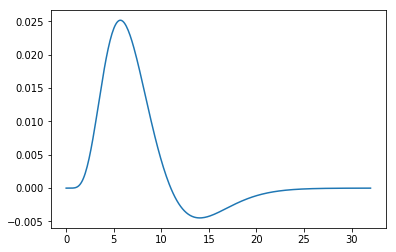

In [81]:
N_trials = 60
true_betas = np.ones(N_trials*2)
true_betas[::2] = np.ones(N_trials)*2
oversampling = 20
TR = 2
trial_dur = 1
hrf = glover_hrf(tr=TR, oversampling=oversampling)
plt.plot(np.linspace(0, hrf.size / oversampling * TR, hrf.size), hrf)
plt.show()

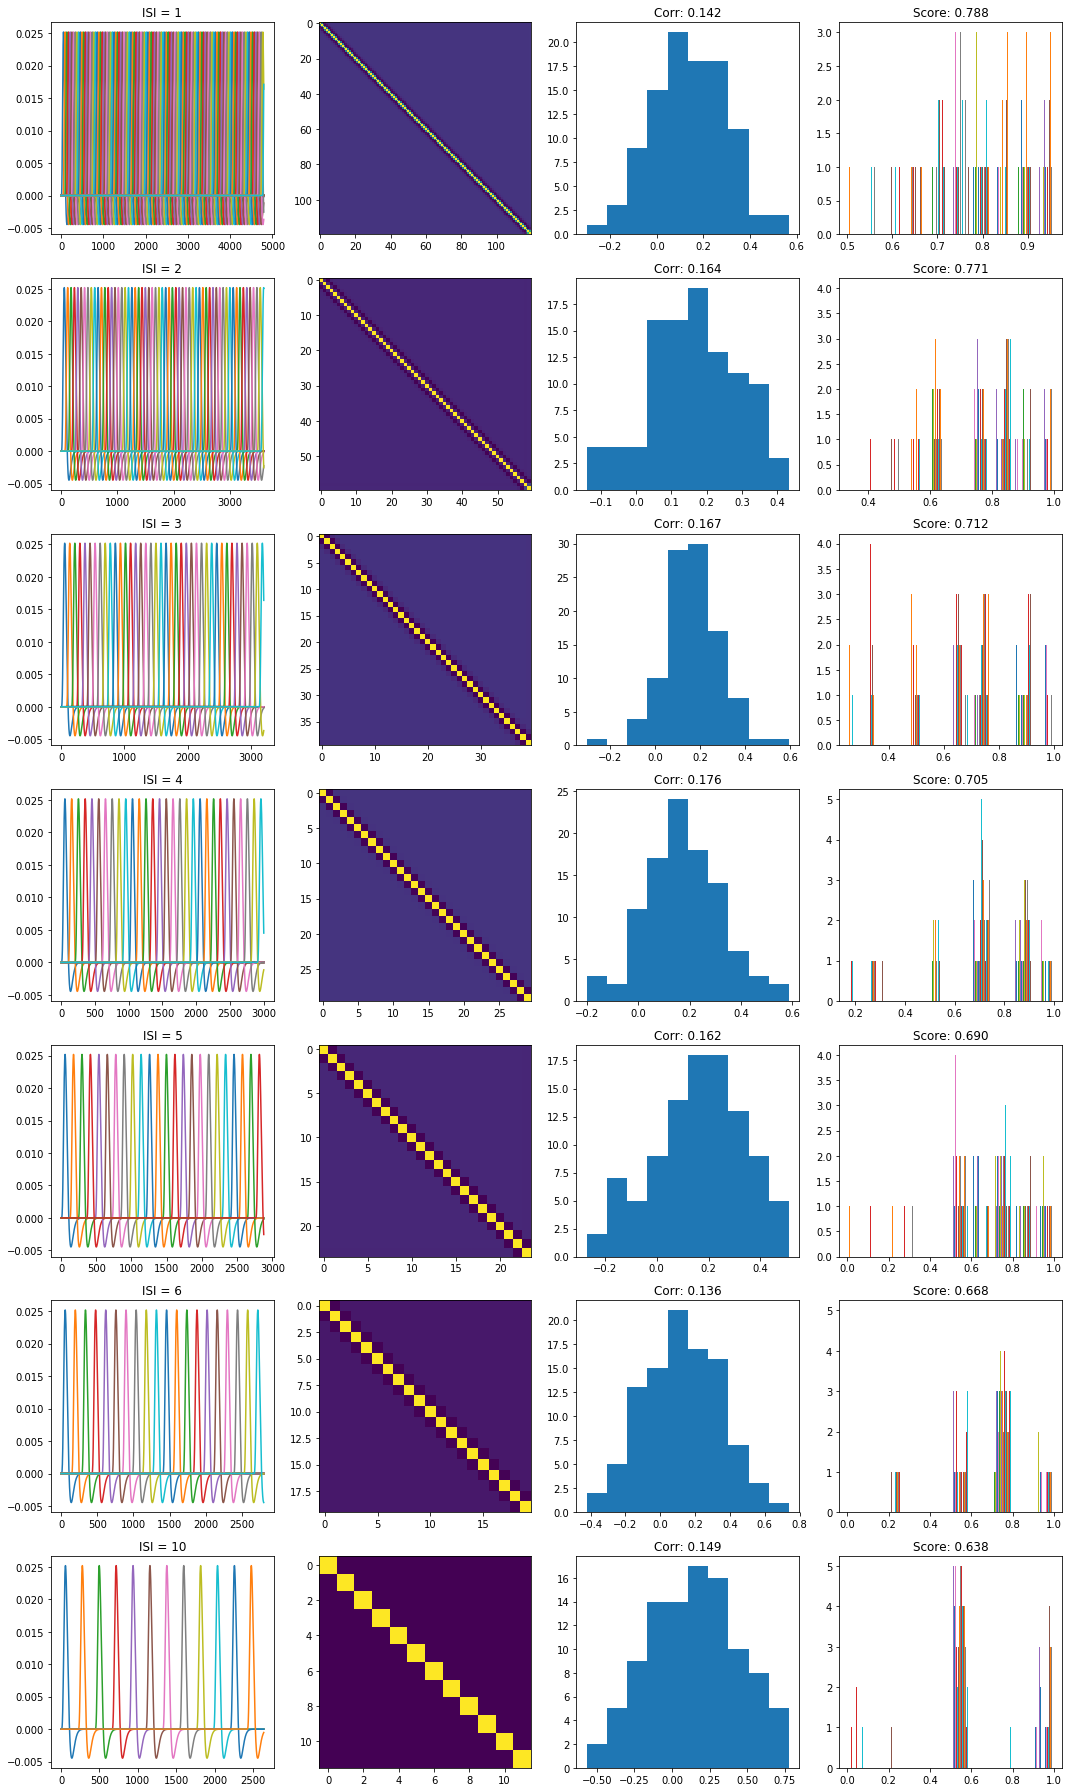

In [107]:
ISIs = [1, 2, 3, 4, 5, 6, 10]
fig, axes = plt.subplots(ncols=4, nrows=len(ISIs), figsize=(15, 25))
pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))
cb_N = True
iters = 100

for i, ISI in enumerate(ISIs):
    
    if cb_N:
        this_N = int(N_trials / ISI)
        tb = true_betas[:int(this_N*2)]
    else:
        this_N = N_trials
        tb = true_betas

    target = np.ones(this_N*2)
    target[::2] = 0
        
    onsets = np.linspace(0, (trial_dur + ISI) * oversampling * this_N * 2, this_N * 2 + 1, dtype=int)[:-1]
    trials = []
    for onset in onsets:
        x = np.zeros((ISI+trial_dur)*this_N*oversampling*2)
        x[onset] = 1
        trials.append(np.convolve(x, hrf)[:x.size, np.newaxis])

    X = np.hstack(trials)
    axes[i, 0].set_title('ISI = %i' % ISI)
    axes[i, 0].plot(X)
    axes[i, 1].imshow(np.corrcoef(X.T))
    
    corrs = []
    scores = []
    est_betas = np.zeros((this_N*2, iters))
    for ii in range(iters):
        y = X.dot(tb) + np.random.normal(0, 1, X.shape[0]) / 2
        est_b = np.linalg.lstsq(X, y, rcond=None)[0]
        est_betas[:, ii] = est_b
        corrs.append(stats.pearsonr(est_b, tb)[0])
        scores.append(cross_val_score(pipe, est_betas, target, cv=5))
        
    axes[i, 2].hist(corrs)
    #axes[i, 2].set_xlim(0.3, 0.7)
    axes[i, 2].set_title("Corr: %.3f" % np.mean(corrs))
    axes[i, 3].hist(scores)
    axes[i, 3].set_title("Score: %.3f" % np.mean(scores))
    
fig.tight_layout()